# NYC Yellow Taxi Growth

#### The objectives of this program:
Using the data set that comes from NYC open data of **NYC Yellow Taxi Service** and **Uber Taxi Service** we would like to **analyze the growth** of the NYC Yellow Taxi Service by using the amount of pickups done daily.

We will be using correlation between taxi and uber in respective borough to observe the **correlation between the growth rate** of both taxi and uber to help understand how competition impacts pickup amounts. We will also use statistics to help **predict the growth** done within the next few days. We will be using **histograms and line charts** to demonstrate the growth.

In [1]:
sc

In [2]:
# imports
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import matplotlib.dates as mpd
import matplotlib.pyplot as plt
import datetime
import csv

## Taxi vs Uber

In [3]:
taxi_aug14 = sc.textFile('../taxi_aug14_200k.csv'   , use_unicode=False).filter(lambda x: x != "").cache()
uber_aug14 = sc.textFile('../uber-raw-data-aug14.csv', use_unicode=False).cache()
# list(enumerate(taxi_aug14.first().split(',')))
# list(enumerate(uber_aug14.first().split(',')))

### Borough Estimation

We will be using midpoints of each respective boughs to where the coordinates of the bus data lies.  
We will use the a default distance of 20 miles as the maximum value away from the midterm (that is Staten Island or Manhattan) ends up being around 20 miles.  
If both borough overlap we will use the closest distance. Otherwise, if it doesn't fall in borough distance we will consider it to be outside NYC.

In [4]:
queensCenter = ((40.800760+40.542920)/2,(-73.700272-73.962616)/2)
brookCenter = ((40.739877+40.57042)/2,(-73.864754-74.04344)/2)
bronxCenter = ((40.915255+40.785743)/2,(-73.765274-73.933406)/2)
manhattanCenter = ((40.874663+40.701293)/2,(-73.910759-74.018721)/2)
siCenter = ((40.651812+40.477399)/2,(-74.034547-74.259090)/2)

boroughDict = {}
boroughDict["queens"] = queensCenter
boroughDict["brooklyn"] = brookCenter
boroughDict["bronx"] = bronxCenter
boroughDict["manhattan"] = manhattanCenter
boroughDict["staten"] = siCenter

def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "outside_nyc"

### Data Ingestion for August 2014 Taxi Data

We will clean the data into:  
```((boro, pickup, 1)```  
Then we will group this data as:  
```[boro [(date, count)]]```

In [5]:
def extractTaxi(partId, records):
    if partId==0:
        records.next()
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[1].split(" ")[0], get_closest_borough(row[6],row[5]))
        yield ((boro, pickup) , 1)

trdd = taxi_aug14.mapPartitionsWithIndex(extractTaxi)\
                .reduceByKey(lambda x, y: x+y)\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y))
#trdd.take(10)

### Data Ingestion for August 2014 Uber Data

Just like the taxi data, we will format the Uber data just the same.

In [6]:
def extractUber(partId, records):
    if partId==0:
        records.next()
    import csv
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[0].split(" ")[0],  get_closest_borough(row[1],row[2]))
        yield ((boro, pickup), 1)

urdd = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y))             
#urdd.take(10)

##### This function will get data from either of the dataset

In [7]:
# gets data given a key
def get_data(data, key):
    # returns ALL values
    if key == -1:
        return data.values().map(lambda x: list(zip(*x)[1])).collect()
    # returns ALL dates
    if key == -2:
        return data.values().map(lambda x: zip(*x)[0]).collect()[4]
    data = zip(*data.collect()[key][1])[1]
    if data:
        return data
    print "None found"
    return []
# don't use index 2 in the actual database because it is 'outside_nyc'
lboro = ['bronx', 'brooklyn', 'queens', 'manhattan', 'staten']

### Scatter Line Graph for Taxi vs Uber

In [8]:
def make_scatter(time, tvalues, uvalues, key):
   # plt.plot(time, tvalues,'-o', c ='blue', label = 'taxi')
    plt.plot(time, uvalues, '-o', c='red', label = 'uber')
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups')
    plt.show()

#### We will first make a scatter to observe the data

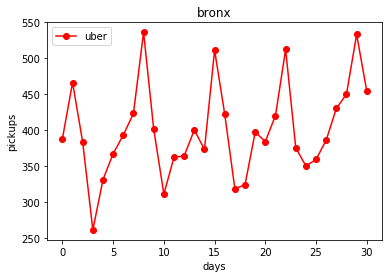

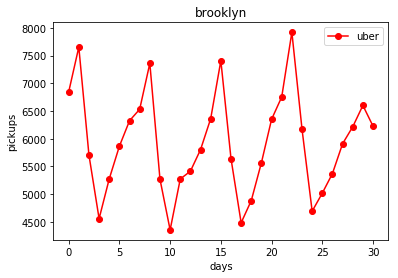

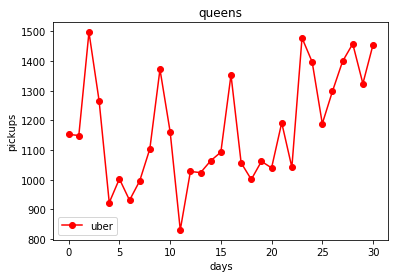

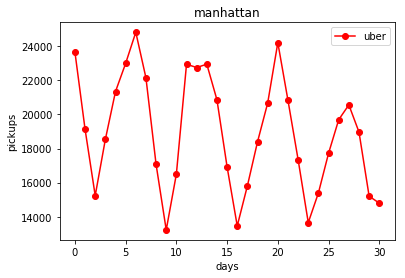

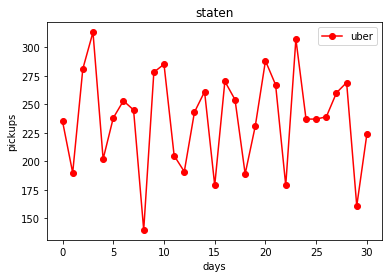

In [11]:
datetimes = list(i for i in range(len(get_data(urdd, -2))))

for i in range(6):
    if i < 2:
        make_scatter(datetimes, get_data(trdd, i), get_data(urdd, i), i)
    elif i > 2:
        make_scatter(datetimes, get_data(trdd, i), get_data(urdd, i), i-1)

### Cumilative Line Graph for Taxi vs Uber

In [12]:
uvb = [[],[],[],[],[]]
tvb = [[],[],[],[],[]]
# evaluate the histogram
tvb[0] = list(np.histogram(get_data(trdd, 0), bins=30))
tvb[1] = list(np.histogram(get_data(trdd, 1), bins=30))
tvb[2] = list(np.histogram(get_data(trdd, 3), bins=30))
tvb[3] = list(np.histogram(get_data(trdd, 4), bins=30))
tvb[4] = list(np.histogram(get_data(trdd, 5), bins=30))

uvb[0] = list(np.histogram(get_data(urdd, 0), bins=30))
uvb[1] = list(np.histogram(get_data(urdd, 1), bins=30))
uvb[2] = list(np.histogram(get_data(urdd, 3), bins=30))
uvb[3] = list(np.histogram(get_data(urdd, 4), bins=30))
uvb[4] = list(np.histogram(get_data(urdd, 5), bins=30))

#evaluate the cumulative
tvb[0][0] = np.cumsum(tvb[0][0])
tvb[1][0] = np.cumsum(tvb[1][0])
tvb[2][0] = np.cumsum(tvb[2][0])
tvb[3][0] = np.cumsum(tvb[3][0])
tvb[4][0] = np.cumsum(tvb[4][0])

uvb[0][0] = np.cumsum(uvb[0][0])
uvb[1][0] = np.cumsum(uvb[1][0])
uvb[2][0] = np.cumsum(uvb[2][0])
uvb[3][0] = np.cumsum(uvb[3][0])
uvb[4][0] = np.cumsum(uvb[4][0])

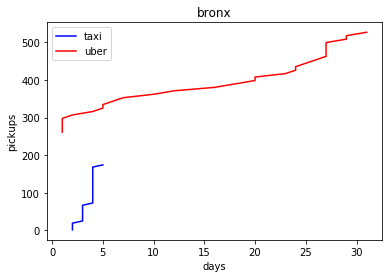

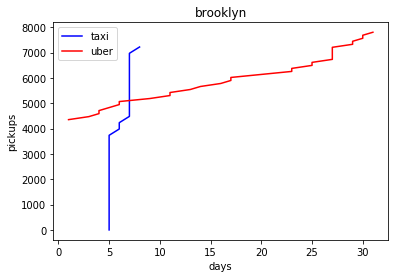

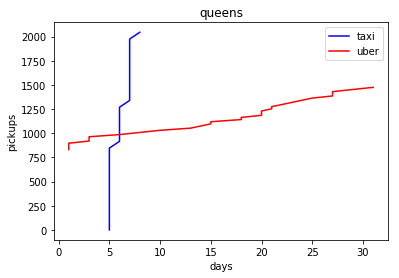

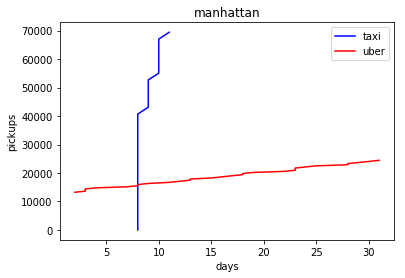

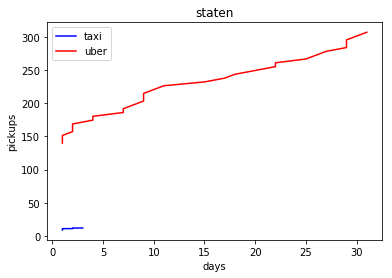

In [13]:
# plot the cumulative functions
def make_accum_graph(key):
    plt.plot(tvb[key][0], tvb[key][1][:-1], c='blue', label = 'taxi')
    plt.plot(uvb[key][0], uvb[key][1][:-1], c='red', label = 'uber')
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups')
    plt.show()
    
for i in range(5):
    make_accum_graph(i)

## Growth Rate Comparison

Then we will make growth rate comparison using histograph of boro based in seperate squares to get a better idea of increase and decrease correlation for both statistics.

In [14]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [15]:
def get_growth(data, key):
    sqlc = SQLContext(sc)

    data = sc.parallelize(data.collect()[key][1])
    df = sqlc.createDataFrame(data, ["date", "value"])
    my_window = Window.partitionBy().orderBy("date")

    df = df.withColumn("prev_value", F.lag(df.value).over(my_window))
    df = df.withColumn("diff", F.when(F.isnull(((df.value - df.prev_value)/df.prev_value)*100), 0)
                                  .otherwise((df.value - df.prev_value)/df.prev_value)*100)
    return df.rdd.map(lambda x: x.date.encode("utf-8")).collect(), df.rdd.map(lambda x: x.diff).collect()

In [16]:
def make_growth_chart(time, tvalues, uvalues, key):
   # plt.plot(time, tvalues,'-o', c ='blue', label = 'taxi')
    plt.plot(time, uvalues, '-o', c='red', label = 'uber')
    plt.axhline(linewidth=3, ls = 'dashed')
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups')
    plt.show()

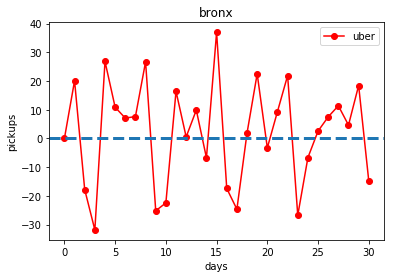

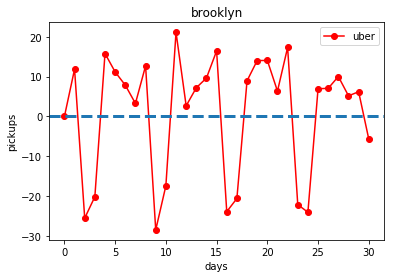

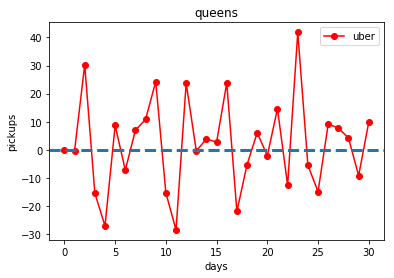

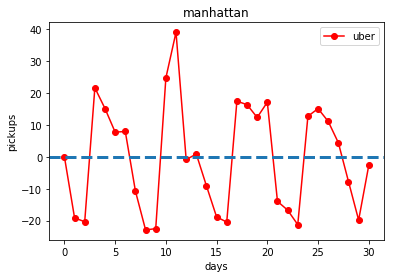

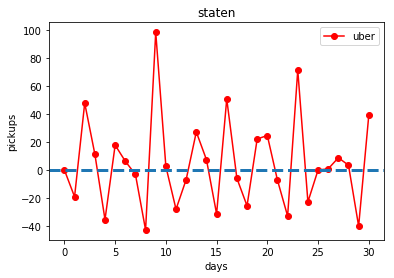

In [18]:
datetimes = list(i for i in range(len(get_data(urdd, -2))))

for i in range(6):
    if i < 2:
        make_growth_chart(datetimes, get_growth(trdd, i)[1], get_growth(urdd, i)[1], i)
    elif i > 2:
        make_growth_chart(datetimes, get_growth(trdd, i)[1], get_growth(urdd, i)[1], i-1)


## Prediction

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [20]:
columns = ['boro', 'days_in_month', 'number_of_pickup']
dic_boro = {'bronx': 0, 'brooklyn': 1, 'manhattan': 2, 'outside_nyc': 3, 'queens': 4, 'staten': 5}

In [21]:
Urdd_table = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (dic_boro[x[0][0]], int(datetime.datetime.strptime(x[0][1], "%Y-%m-%d").strftime("%d")),x[1]))
                               # (x[1]-min_boro[dic_boro[x[0][0]]])/(max_boro[dic_boro[x[0][0]]]- min_boro[dic_boro[x[0][0]]])))

In [22]:
df_urdd = Urdd_table.collect()
'''df = pd.DataFrame(Urdd_table.collect(), columns=columns)
df_boro = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(len(df)):
        if df['boro'][j] == i:
            df_boro[i].append(df.loc[j].values)
'''


"df = pd.DataFrame(Urdd_table.collect(), columns=columns)\ndf_boro = [[],[],[],[],[],[]]\nfor i in range(6):\n    for j in range(len(df)):\n        if df['boro'][j] == i:\n            df_boro[i].append(df.loc[j].values)\n"

In [23]:
df_boro = [[],[],[],[],[],[]]
for i in range(6):
    for item in df_urdd:
        if item[0] == i:
            df_boro[i].append(item)
for i in range(6):
    df_boro[i] = pd.DataFrame(df_boro[i], columns=columns)

In [25]:
X = [[],[],[],[],[],[]]
y =[[],[],[],[],[],[]]
X_train=[[],[],[],[],[],[]]
X_test=[[],[],[],[],[],[]]
y_train=[[],[],[],[],[],[]] 
y_test=[[],[],[],[],[],[]]

for i in range(6):
    X[i] = df_boro[i][['boro', 'days_in_month']].values
    y[i] = df_boro[i][['number_of_pickup']].values
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.4, random_state=1)
    print(X_train[i].shape, X_test[i].shape)

((18L, 2L), (13L, 2L))
((18L, 2L), (13L, 2L))
((18L, 2L), (13L, 2L))
((18L, 2L), (13L, 2L))
((18L, 2L), (13L, 2L))
((18L, 2L), (13L, 2L))


### Cumilative Line Graph for Taxi vs Uber

In [26]:
linear_r = LinearRegression()
lasso_r = Lasso()
ridge_r = Ridge(alpha=1.0)
elastic_r = ElasticNet(alpha=1, l1_ratio=0.5)

In [31]:
for i in range(6):
    linear_r.fit(X_train[i], y_train[i])
    lasso_r.fit(X_train[i], y_train[i])
    ridge_r.fit(X_train[i], y_train[i])
    elastic_r.fit(X_train[i], y_train[i])
    print(lasso_r.predict(df_boro[i][['boro', 'days_in_month']].values))


[ 391.43228537  393.7936316   396.15497783  398.51632406  400.87767029
  403.23901653  405.60036276  407.96170899  410.32305522  412.68440145
  415.04574768  417.40709391  419.76844015  422.12978638  424.49113261
  426.85247884  429.21382507  431.5751713   433.93651753  436.29786376
  438.65921     441.02055623  443.38190246  445.74324869  448.10459492
  450.46594115  452.82728738  455.18863362  457.54997985  459.91132608
  462.27267231]
[ 6267.3337364   6258.20757759  6249.08141878  6239.95525998  6230.82910117
  6221.70294236  6212.57678356  6203.45062475  6194.32446594  6185.19830713
  6176.07214833  6166.94598952  6157.81983071  6148.69367191  6139.5675131
  6130.44135429  6121.31519549  6112.18903668  6103.06287787  6093.93671906
  6084.81056026  6075.68440145  6066.55824264  6057.43208384  6048.30592503
  6039.17976622  6030.05360742  6020.92744861  6011.8012898   6002.675131
  5993.54897219]
[ 21184.90628779  21031.7382104   20878.57013301  20725.40205562
  20572.23397823  20419